In [1]:
from ultralytics import YOLOWorld
import supervision as sv
import cv2
import numpy as np

In [2]:
!YOLO checks



Ultralytics YOLOv8.2.87 🚀 Python-3.11.9 torch-2.3.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3050 4GB Laptop GPU, 4096MiB)
Setup complete ✅ (16 CPUs, 15.7 GB RAM, 56.2/62.5 GB disk)

OS                  Windows-10-10.0.22631-SP0
Environment         Windows
Python              3.11.9
Install             git
RAM                 15.68 GB
CPU                 13th Gen Intel Core(TM) i5-13500H
CUDA                11.8

numpy               ✅ 1.26.3<2.0.0,>=1.23.0
matplotlib          ✅ 3.9.2>=3.3.0
opencv-python       ✅ 4.10.0.84>=4.6.0
pillow              ✅ 10.2.0>=7.1.2
pyyaml              ✅ 6.0.2>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.14.1>=1.4.1
torch               ✅ 2.3.1+cu118>=1.8.0
torchvision         ✅ 0.18.1+cu118>=0.9.0
tqdm                ✅ 4.66.5>=4.64.0
psutil              ✅ 6.0.0
py-cpuinfo          ✅ 9.0.0
pandas              ✅ 2.2.2>=1.1.4
seaborn             ✅ 0.13.2>=0.11.0
ultralytics-thop    ✅ 2.0.6>=2.0.0
torch               ✅ 2.3.1+cu118<2.4.0,>=1.

In [3]:
# Initialize a YOLO-World model
# model = YOLOWorld(r"models\yolov8x-worldv2.pt")  # or select yolov8m/l-world.pt for different size
model = YOLOWorld(r"models\yolov10m.pt")

In [41]:
model.set_classes(['vehicle'])

AttributeError: 'DetectionModel' object has no attribute 'set_classes'

In [4]:
model.to('cuda')  # or 'cpu'
model.device

device(type='cuda', index=0)

In [5]:
VIDEO = r"videos\highway_two_lane.mp4"

In [6]:
colors = sv.ColorPalette.DEFAULT
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

VideoInfo(width=1920, height=1080, fps=29, total_frames=1275)

In [7]:
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

# First fame of the video
frame = next(iterator)

# save first frame
cv2.imwrite(r"images\first_frame.png", frame)

True

In [8]:

polygons = [
  np.array([
    [718, 595],[927, 592],[851, 1062],[42, 1059]
  ]),
  np.array([
    [987, 595],[1199, 595],[1893, 1056],[1015, 1062]
  ])
]

In [9]:
# initialize our zones

zones = [
    sv.PolygonZone(
        polygon=polygon,
    )
    for polygon in polygons
]

zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone in enumerate(zones)
]

box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4
    )
    for index in range(len(polygons))
]

In [10]:
def process_frame(frame: np.ndarray, i) -> np.ndarray:

    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
        frame = zone_annotator.annotate(scene=frame)

    return frame

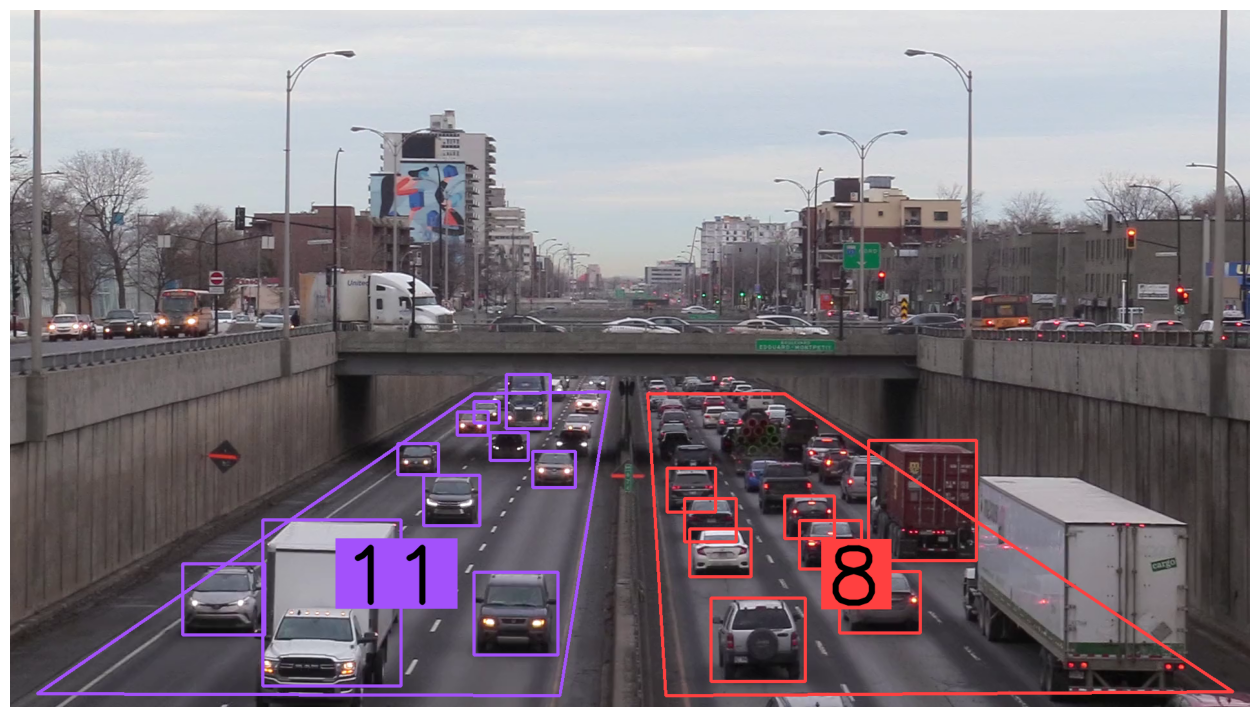

In [11]:
results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

In [12]:
sv.process_video(source_path=VIDEO, target_path="result_yolov10m.mp4", callback=process_frame)

In [29]:
def show_video(video_path: str):
    cap = cv2.VideoCapture(video_path)
    frame_index = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Process the frame
        processed_frame = process_frame(frame, frame_index)
        frame_index += 1

        # Display the processed frame
        cv2.imshow('Processed Video', processed_frame)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [30]:
# Call the function to show the video
show_video('path_to_your_video.mp4')

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'


In [6]:
# Execute inference with the YOLOv8s-world model on the specified image
results = model.predict(r"images\vlcsnap.png")

# Show results
results[0].show()


image 1/1 d:\Major Project\images\vlcsnap.png: 640x384 4 cars, 121.2ms
Speed: 1.0ms preprocess, 121.2ms inference, 66.5ms postprocess per image at shape (1, 3, 640, 384)


In [12]:
# Track with a YOLO-World model on a video
results = model.track(source=r"videos\highway.mp4", stream=True)

# Show results